In [1]:
from datacov import TopoGen
from datacov import VoroGeom, CircleGeom, ConvexGeom, ConcaveGeom, DistGen, VoroSiteGeom
from datacov import get_pr_band, evaluate, get_pr_band_site, evaluate_mapl_models, tune_scale
from datacov import RevHata, RevMa, GenMAPL
import matplotlib.pyplot as plt
import random

import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
band_params = {
    'bands': [800, 2600],
    'band_probs': [1., 0.6],
    'ue_dist_scale': [300, 150],
    'ue_dist_loc': [500, 200]
}
topo = TopoGen(**band_params, minlim=1000, maxlim=3500, n_sites=6, n_ue=30)
_, _ = topo.generate_topo()

topo_mapl = topo.cells.drop('geometry', axis=1).merge(topo.sites.drop('geometry', axis=1), on=['bs_id', 'x', 'y'])

voro = VoroGeom.from_topo(topo)
circle = CircleGeom.from_topo(topo)
cvx = ConvexGeom.from_topo(topo)
ccv = ConcaveGeom.from_topo(topo)

scales = np.arange(0.3, 2.1, 0.1)
n_prb_range = np.arange(1, 51, 1)

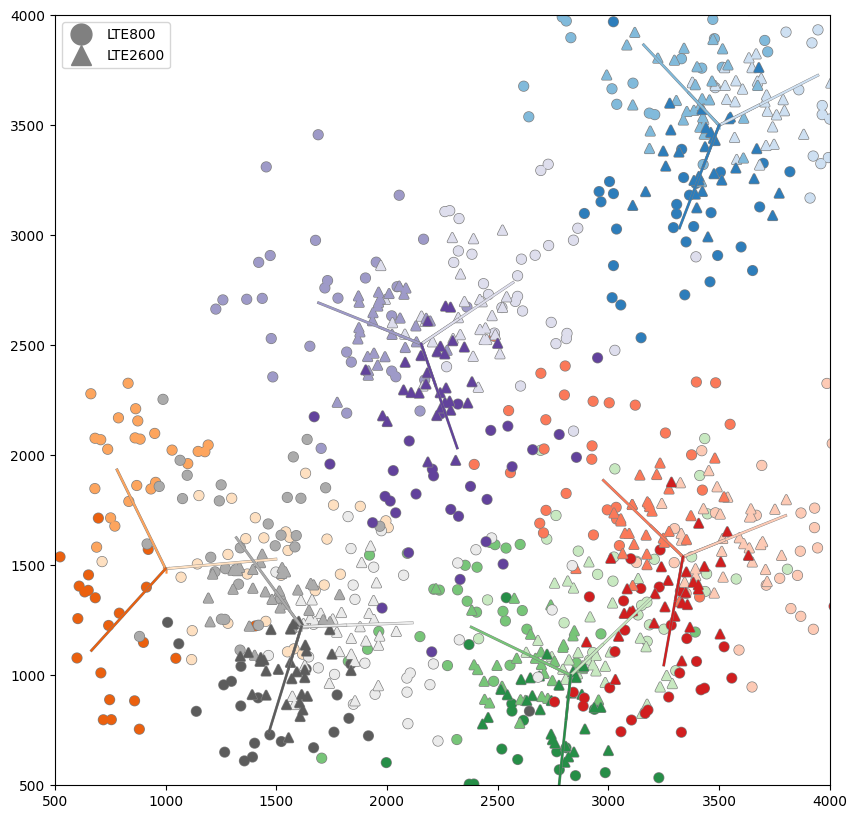

In [3]:
topo.plot_topography()

In [4]:
voro_p, voro_r = evaluate(voro, scales)
context = ['urban', 'suburban', 'rural']
weights = [0.4, 0.4, 0.2] 
context_array = random.choices(context, k=topo_mapl.shape[0], weights=weights)

vhata_p, vhata_r = evaluate_mapl_models(n_prb_range=n_prb_range, mapl_model=GenMAPL, mapl_context=context_array, topo_mapl=topo_mapl, rev_model=RevHata, coverage_shape=voro)
chata_p, chata_r = evaluate_mapl_models(n_prb_range=n_prb_range, mapl_model=GenMAPL, mapl_context=context_array, topo_mapl=topo_mapl, rev_model=RevHata, coverage_shape=circle)
cma_p, cma_r = evaluate_mapl_models(n_prb_range=n_prb_range, mapl_model=GenMAPL, mapl_context=context_array, topo_mapl=topo_mapl, rev_model=RevMa, coverage_shape=circle)
vma_p, vma_r = evaluate_mapl_models(n_prb_range=n_prb_range, mapl_model=GenMAPL, mapl_context=context_array, topo_mapl=topo_mapl, rev_model=RevMa, coverage_shape=voro)

cvx_p, cvx_r = get_pr_band(cvx)
ccv_p, ccv_r = get_pr_band(ccv)

dg = DistGen(topo).generate_distances()
tuned_voro = tune_scale(dg, voro)

vorositecell = VoroSiteGeom.from_voro_geom(voro)
vorositecell_p, vorositecell_r = evaluate(vorositecell)
vorosite_p, vorosite_r = evaluate(vorositecell, pr_func=get_pr_band_site)

factors = list(VoroGeom.compute_scale(circle, voro))
vorocircle = CircleGeom.scale_cell_shapes(circle, factors)
vorocircle_p, vorocircle_r = evaluate(vorocircle)

100%|██████████| 18/18 [00:02<00:00,  7.68it/s]


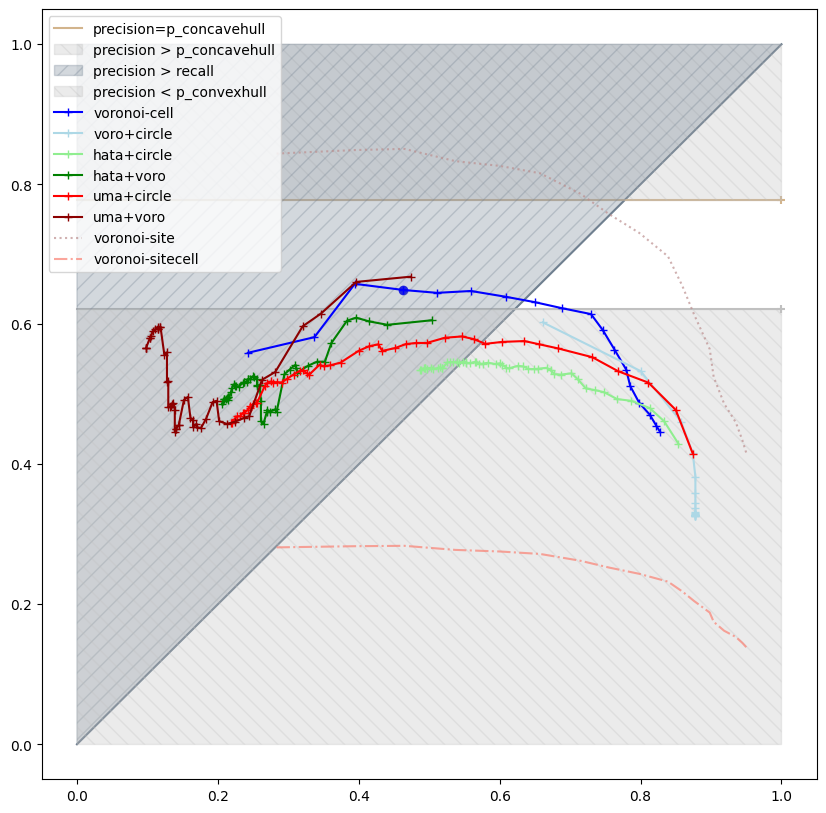

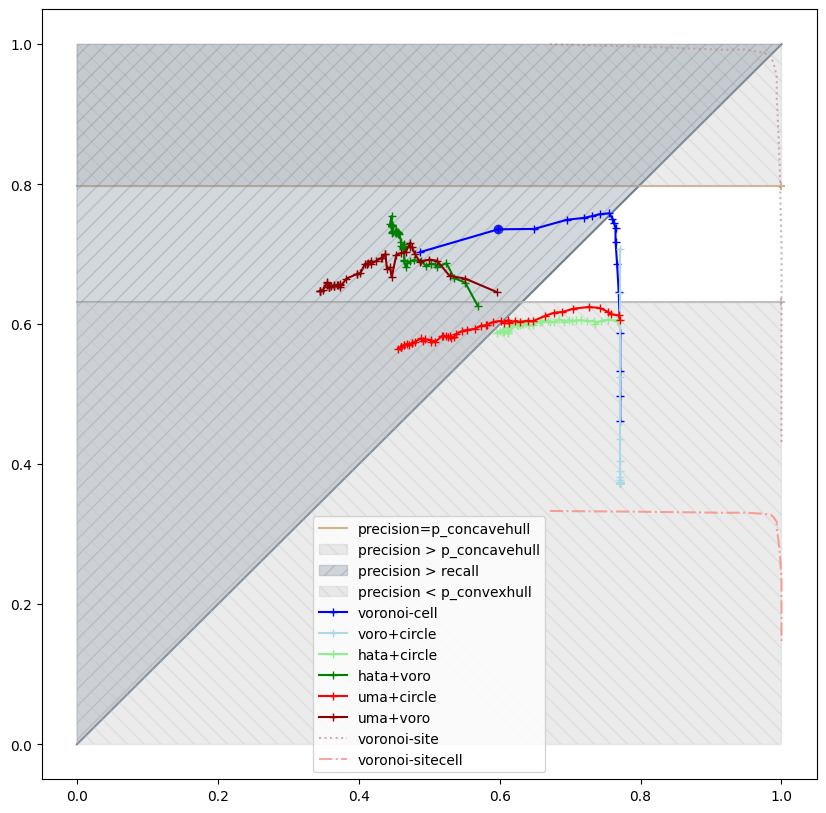

In [5]:
x = [0, 1]
y_convex_col = "Silver"
y_concave_col = 'Tan'

xy = [0., 1.]
xy_col = 'SlateGrey'
y_1 = [1., 1.]

for i in range(len(topo.bands)):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # concave hull
    y_concave = [ccv_p[i], ccv_p[i]]
    ax.plot(x, y_concave, label='precision=p_concavehull', color=y_concave_col)
    ax.scatter([1], [ccv_p[i]], marker='+', color=y_concave_col)
    ax.fill_between([0, 1], y_concave, [1., 1.], color=y_convex_col, alpha=0.3, zorder=2, label='precision > p_concavehull', hatch='\\\\')
    
    # y = x
    ax.plot(xy, xy, xy_col, zorder=0)
    ax.fill_between([0, 1], xy, y_1, color=xy_col, alpha=0.3, zorder=2, label='precision > recall', hatch='//')
    
    # convex hull
    y_convex = [cvx_p[i], cvx_p[i]]
    ax.plot(x, y_convex, y_convex_col, zorder=0)
    ax.scatter([1], [cvx_p[i]], marker='+', color=y_convex_col)
    ax.fill_between([0, 1], y_convex, color=y_convex_col, alpha=0.3, zorder=2, label='precision < p_convexhull', hatch='\\\\')
           
    voro_ax, = ax.plot(voro_r[i], voro_p[i], '+-', label='voronoi-cell', color='Blue')
    ax.scatter(voro_r[i][int(tuned_voro.scale_idx[i])], voro_p[i][int(tuned_voro.scale_idx[i])], color='Blue')
    
    vorocircle, = ax.plot(vorocircle_r[i], vorocircle_p[i], '+-', label='voro+circle', color='LightBlue')
    hata, = ax.plot(chata_r[i], chata_p[i], '-+', label='hata+circle', color='LightGreen')
    vorohata, = ax.plot(vhata_r[i], vhata_p[i], '-+', label='hata+voro', color='Green')
    uma, = ax.plot(cma_r[i], cma_p[i], '-+', label='uma+circle', color='Red')
    vorouma, = ax.plot(vma_r[i], vma_p[i], '-+', label='uma+voro', color='DarkRed')
    
    vorosite_ax, = ax.plot(vorosite_r[i], vorosite_p[i], ':', alpha=0.7, label='voronoi-site', color='RosyBrown')
    vorositecell_ax, = ax.plot(vorositecell_r[i], vorositecell_p[i], '-.', alpha=0.7, label='voronoi-sitecell', color='Salmon')
        
    plt.legend()